In [1]:
import openseespy.opensees as ops
import opsvis as opsv
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import Tools.Resultados as rs             # type: ignore

[Hurtado, 2013 - Análisis Matricial de Estructuras](https://repositorio.unal.edu.co/bitstream/handle/unal/12205/jorgeeduardohurtadogomez.2013.pdf#page=20)  
📄 Ejemplo ubicado en la página 20.

# 1.7. EJEMPLO 1 -  Columna de sección variable.

Consideremos la estructura mostrada en la figura 1.7, que consiste en tres elementos de diferente área seccional sometidos a una carga de compresión de valor 1200 kN. Las áreas de los elementos son $A_1 = 0,25$, $A_2 = 0,16$ y $A_3 = 0,09m^2$, mientras que el módulo de elasticidad es $E = 2×10^7kN/m^2$ para todos ellos. La longitud de cada elemento es de $1m$

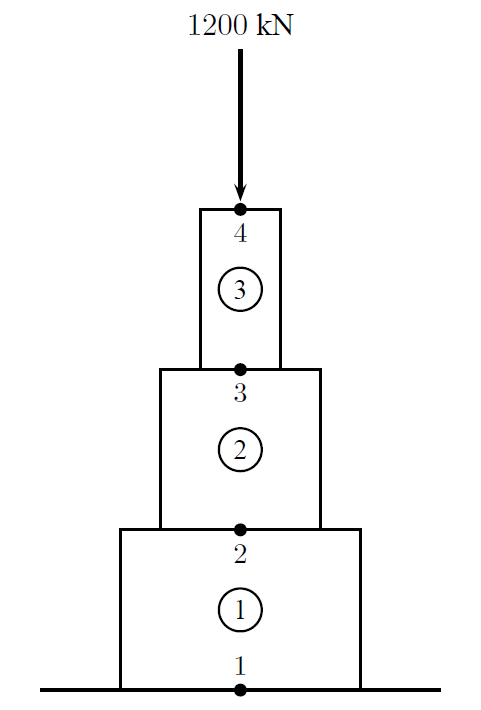

In [2]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

### Nodos y Elementos 

<Axes: >

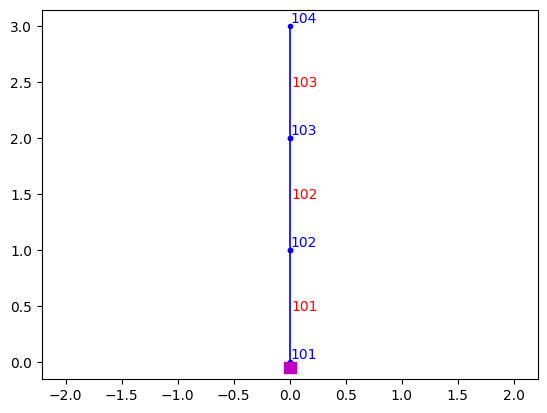

In [3]:
# Coordenadas de los Nodos -----------------------------------------------------------------------
L = 1
Nodos = [101, 102, 103, 104]

Longi = []                      # Inicializamos una lista vacía para las longitudes acumuladas
acumulado = 0                   # Variable para ir acumulando la longitud

for i in range(len(Nodos)):     # Recorremos los nodos y vamos acumulando la longitud
    Longi.append(acumulado)
    ops.node(Nodos[i], 0., acumulado)
    acumulado += L

# Condiciones de Apoyo ---------------------------------------------------------------------------
ops.fix(101, 1, 1, 1)

# Elementos --------------------------------------------------------------------------------------
ops.geomTransf('Linear', 1)
E_Mod = 2 * 10 ** 7
Iz = 1
Ai = [0.25, 0.16, 0.09]
Ele = [101, 102, 103]

for i in range(len(Ele)):     # Recorremos los elementos
    ops.element('elasticBeamColumn', Ele[i], Nodos[i], Nodos[i+1], Ai[i], E_Mod, Iz, 1)
opsv.plot_model()

### Cargas 

In [4]:
P = 1200.0
ops.timeSeries('Constant',1)
ops.pattern('Plain',1 ,1)
#eleLoad('-ele', 101, '-type', '-beamUniform', -W)
ops.load(104, 0., -P, 0.)

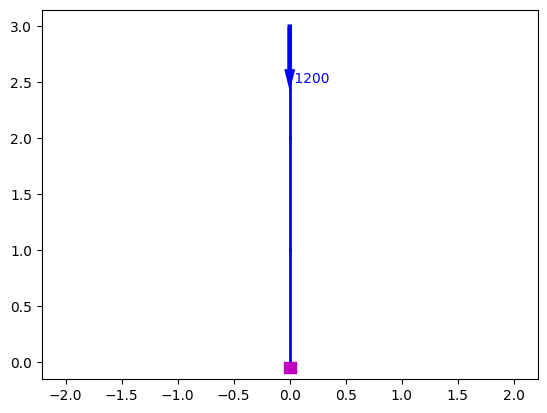

In [16]:
# Definir parámetros de ejemplo
nep = 2                             # Número de puntos por elemento
sfac = 0.5                          # Factor de escala
fig_wi_he = (8, 6)                  # Ancho y alto de la figura
fig_lbrt = (0.1, 0.1, 0.9, 0.9)     # Márgenes
fmt_model_loads = {'color': 'b', 'linewidth': 2}    # Formato de cargas
node_supports = True                                # Diccionario con información de apoyos (según el modelo)
truss_node_offset = 0.1                             # Desplazamiento de nodos en elementos tipo truss

fig, ax = plt.subplots()                            # Crear figura y ejes
opsv.plot_loads_2d(nep, sfac, fig_wi_he, fig_lbrt, fmt_model_loads, node_supports, truss_node_offset, ax)
plt.show()

### Análisis

Análisis Gravitacional Exitoso


np.float64(234.07022106632)

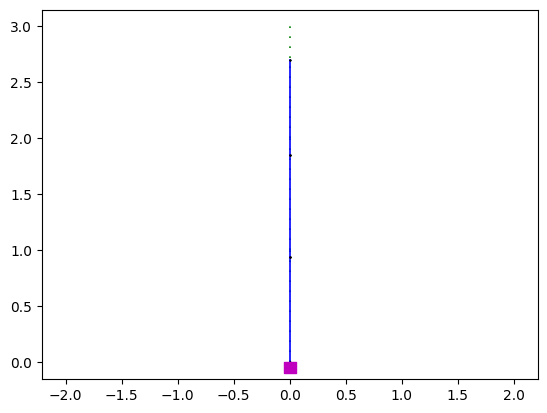

In [6]:
rs.analisis_gravitacional()
opsv.plot_defo()

### Resultados

In [7]:
rs.reacciones_OPS(Nodos)
rs.desplazamientos_OPS(Nodos)
rs.fuerzaslocales_OPS(Ele)
rs.deformaciones_OPS(Ele)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0.5, 1.0, 'Axial force distribution')

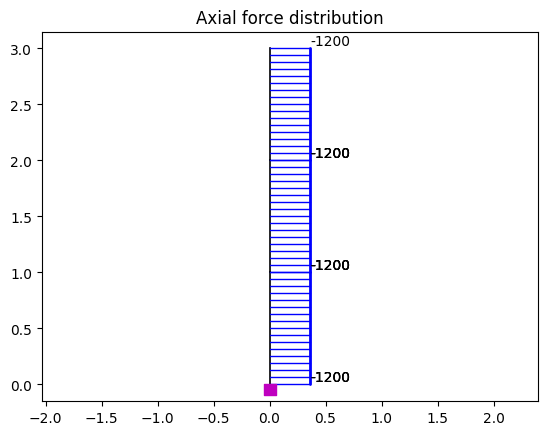

In [8]:
sfacN, sfacV, sfacM = 3.e-4, 5.e-5, 5.e-5

opsv.section_force_diagram_2d('N', sfacN)
plt.title('Axial force distribution')
#opsv.section_force_diagram_2d('T', sfacV)
#plt.title('Shear force distribution')
#opsv.section_force_diagram_2d('M', sfacM)
#plt.title('Bending moment distribution')

# 1.7. EJEMPLO 1 -  Columna de sección variable.
## Análisis matricial de estructuras / Curso con MATLAB

In [9]:
def rigidez(E, Ai):
    ki = E * Ai * np.array([[1, -1], [-1, 1]])
    return ki

k1 = rigidez(E_Mod, Ai[0])
k2 = rigidez(E_Mod, Ai[1])
k3 = rigidez(E_Mod, Ai[2])

In [10]:
K = np.zeros((4, 4))                    # Inicializar la matriz global de rigidez 4x4

g_1 = [0, 1]
DeltaK_1 = np.zeros((4, 4))
DeltaK_1[np.ix_(g_1, g_1)] = k1
K += DeltaK_1

g_2 = [1, 2]
DeltaK_2 = np.zeros((4, 4))
DeltaK_2[np.ix_(g_2, g_2)] = k2
K += DeltaK_2

g_3 = [2, 3]
DeltaK_3 = np.zeros((4, 4))
DeltaK_3[np.ix_(g_3, g_3)] = k3
K += DeltaK_3

In [11]:
P = np.array([0, 0, 0, -1200], dtype=float)     # P está definido

a, b = [0], [1, 2, 3]                   # Grados de libertad restringidos y libres

# Información de los elementos
g_list = [g_1, g_2, g_3]                # Grados de libertad por elemento
k_list = [k1, k2, k3]                   # Matrices de rigidez por elemento

K_aa = K[np.ix_(a, a)]                  # Submatrices
K_ab = K[np.ix_(a, b)]
K_ba = K[np.ix_(b, a)]
K_bb = K[np.ix_(b, b)]

P_b = P[b]                              # Subvector de fuerzas externas
D_b = np.linalg.solve(K_bb, P_b)        # Resolver desplazamientos en grados de libertad libres
P_a = K_ab @ D_b                        # Calcular las reacciones en los apoyos
D = np.zeros((4,))                      # Construir vector global de desplazamientos
D[b] = D_b

d_1 = D[g_1]                            # Desplazamientos del elemento 1
p_1 = k1 @ d_1                          # Fuerzas del elemento 1

Q_ab = K_ab @ D_b                       # Calcular reacciones (Q)
Q = np.zeros_like(P)                    # Vector Q con reacciones en la posición correcta
Q[a] = Q_ab

In [12]:
rs.desplazamientos_OPS(Nodos)
rs.desplazamientosNodos_Matlab(D)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [13]:
rs.reacciones_OPS(Nodos)
rs.reacciones_Matlab(Q)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [14]:
rs.fuerzaslocales_OPS(Ele)
rs.fuerzasinternas_Matlab(g_list, k_list, D)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [15]:
rs.deformaciones_OPS(Ele)
rs.deformacionesElementos_Matlab(g_list, D)

<IPython.core.display.Math object>

<IPython.core.display.Math object>